# Generates shuffled embeddings

- shuffled datas by trial

@emilyekstrum
<br> 11/17/25


In [ ]:
import cebra
import itertools
import os
import torch
import matplotlib
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

from cebra import CEBRA
from glob import glob
from pathlib import Path

import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from ripser import ripser
import random
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from persim import plot_diagrams
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform

c:\Users\denmanlab\.conda\envs\topology\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
# utils
# Load in data
def load_embedding_data(filepath):
    """Loads in embedding stored in pickle file
    See clean_embeddings.ipynb for more specific details"""

    with open(filepath, "rb") as f:
        single_session_dict = pkl.load(f)
        session_names = list(single_session_dict.keys())
        
    return single_session_dict, session_names

def fps_downsample_embedding(embed, n_target=1000, method="fps", seed=42):
    N = embed.shape[0]
    if n_target >= N:
        return embed  
    
    rng = np.random.default_rng(seed)

    if method == "random":
        idx = rng.choice(N, size=n_target, replace=False)
        return embed[idx]

    elif method == "fps":
        idxs = [rng.integers(N)]
        dists = np.linalg.norm(embed - embed[idxs[0]], axis=1)

        for _ in range(1, n_target):
            next_idx = np.argmax(dists)
            idxs.append(next_idx)
            new_dists = np.linalg.norm(embed - embed[next_idx], axis=1)
            dists = np.minimum(dists, new_dists)

        return embed[idxs]

    else:
        raise ValueError("method must be 'random' or 'fps'")
    

# Embedding to KNN sparse matrix
def knn_sparse_dist(embedding, n_neighbors=300, metric="euclidean", plot = False, plot_title= " "):
    """Makes symmetric KNN sparse distance matrix -> input for ripser
    
    Args:
        embedding (np.ndarray): 2D array of shape (n_samples, n_features)
        n_neighbors (int): Number of nearest neighbors to consider
        metric (str): Distance metric to use
        plot (bool): Whether to plot heatmap of distance matrix
        plot_title (str): Title for the heatmap plot
    Returns:   
        csr_matrix: Sparse distance matrix in CSR format"""
    
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, n_jobs=-1)
    nn.fit(embedding)
    distances, indices = nn.kneighbors(embedding, return_distance=True)        
    num_samples = embedding.shape[0]
    rows = np.repeat(np.arange(num_samples), n_neighbors)
    cols = indices.ravel()
    vals = distances.ravel().astype(np.float32)

    sparse_matrix = csr_matrix((vals, (rows, cols)), shape=(num_samples, num_samples))
    # Symmetrize with min distance on shared edges
    sparse_matrix = sparse_matrix.minimum(sparse_matrix.transpose())

    if plot == True:
        m = min(600, sparse_matrix.shape[0])
        dense_sub = sparse_matrix[:m, :m]
        mask_sub = (dense_sub == 0)

        sns.heatmap(dense_sub, mask=mask_sub, cmap='viridis', square=True, cbar_kws ={'label' : 'Distance'})
        plt.title(plot_title)
        plt.show()
    return sparse_matrix


# Ripser
def tda_ripser(distance_matrix, name, maxdim=2, 
               region='LGN', dims=3, stim = "cex", embed_type = "CEBRA",
               plot = False):
    """ Computes persistence diagrams 
    
    Args:
        distance_matrix (csr_matrix): Sparse distance matrix in CSR format
        name (str): Name of the dataset
        maxdim (int): Maximum homology dimension to compute
        region (str): Brain region
        dims (int): Embedding dimensions
        stim (str): Stimulus type
        embed_type (str): Type of embedding used
        plot (bool): Whether to plot persistence diagrams
    Returns:
        dgms (list): List of persistence diagrams for each dimension"""

    dgms = ripser(distance_matrix, distance_matrix=True, maxdim=maxdim)['dgms']
    if plot == True:
        plot_diagrams(dgms, title=(f"Persistence Diagram of {name} - {stim}"), show=True)

    
    return dgms

def load_embedding_data(filepath):

    with open(filepath, "rb") as f:
        single_session_dict = pkl.load(f)
        session_names = list(single_session_dict.keys())
        
    return single_session_dict, session_names

def plot_3d_CEBRA(filepath, ncols=4):
    """Plots 3D CEBRA embeddings for multiple sessions"""
    
    single_session, session_names = load_embedding_data(filepath)

    n=len(session_names)
    n_rows=int(np.ceil(n/ncols))

    fig = plt.figure(figsize=(20,4))

    for n, name in enumerate(session_names):
        embedding = single_session[name]['embedding']
        
        ax = plt.subplot2grid((2, 8), (0, n), projection='3d')
        ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], s=5, alpha=0.3,cmap='hsv', c=np.linspace(0,1,len(embedding)), 
                   clim=(0,1), rasterized=True)
        ax.set_title(name, y=0.8)
        
        ax = plt.subplot2grid((2, 8), (1, n), projection='3d')
        ax.scatter(embedding[:,0],
                embedding[:,1],
                embedding[:,2],
                s=5, alpha=0.3,
                cmap='hsv', c=np.linspace(0,1,len(embedding)), clim=(0,1), rasterized=True
                )

    for axs in fig.get_axes():
        axs.axis('off')
        axs.grid(False)
        axs.xaxis.pane.fill = False
        axs.yaxis.pane.fill = False
        axs.zaxis.pane.fill = False
        axs.xaxis.pane.set_edgecolor('w')
        axs.yaxis.pane.set_edgecolor('w')
        axs.zaxis.pane.set_edgecolor('w')

    plt.subplots_adjust(wspace=0,
                        hspace=0)
    plt.suptitle('LGN Time')
    plt.tight_layout()
    # plt.savefig(r'G:\cebra_v1_time.pdf',transparent=True)
    plt.show()

In [69]:
# load in raw data
with open(r"C:\Users\denmanlab\Desktop\Emily_rotation\shuffled_raw_data\shuffled_raw_data\V1drifting_gratings_shuffled.pkl", 'rb') as f:
    loaded = pkl.load(f)
    datas = loaded['datas']
    recordings = loaded['recordings']

In [ ]:
#Train CEBRA model 
train_steps = 30000

single_session = dict()
device = 'cuda'

good_recordings = ["C159", "C160"]

cebra_time_model = CEBRA(model_architecture = 'offset10-model',
                        batch_size         = 512,
                        learning_rate      = 3e-4,
                        #  temperature_mode   = "auto",
                        temperature        = 1,
                        #  min_temperature    = 1e-1,
                        output_dimension   = 32,
                        max_iterations     = train_steps,
                        num_hidden_units   = 128,
                        distance           = 'cosine',
                        conditional        = 'time', # time delta uses behavior/stimulus data to fit model
                        device             = device,
                        verbose            = True,
                        time_offsets       = 10,
                        optimizer          = 'adam',
                        )

for name, X in zip(good_recordings, datas):
    print(name)
    out_path = Path(os.path.join(r'G:\cebra',name))
    out_path.mkdir(exist_ok=True)
    single_session[name] = {}

    X = torch.from_numpy(X)
    cebra_time_model.fit(X.type(torch.FloatTensor))
    cebra_time = cebra_time_model.transform(X.type(torch.FloatTensor))

    cebra_time_model.save(os.path.join(out_path,f'{name}_lgn_time.pt'),backend='torch')

    single_session[name]['model']      = cebra_time_model
    single_session[name]['embedding']  = cebra_time
    


C159


pos: -0.9685 neg:  6.2768 total:  5.3082 temperature:  1.0000: 100%|██████████| 30000/30000 [02:56<00:00, 169.99it/s]


C160


pos: -0.3246 neg:  6.3170 total:  5.9924 temperature:  1.0000: 100%|██████████| 30000/30000 [02:54<00:00, 171.85it/s]


In [72]:

with open(r'C:\Users\denmanlab\Desktop\Emily_rotation\CEBRA\32d\shuffled\embeddings\V1_32d_shuffled_drifting_gratings.pkl','wb') as f:
    pkl.dump(single_session,f)


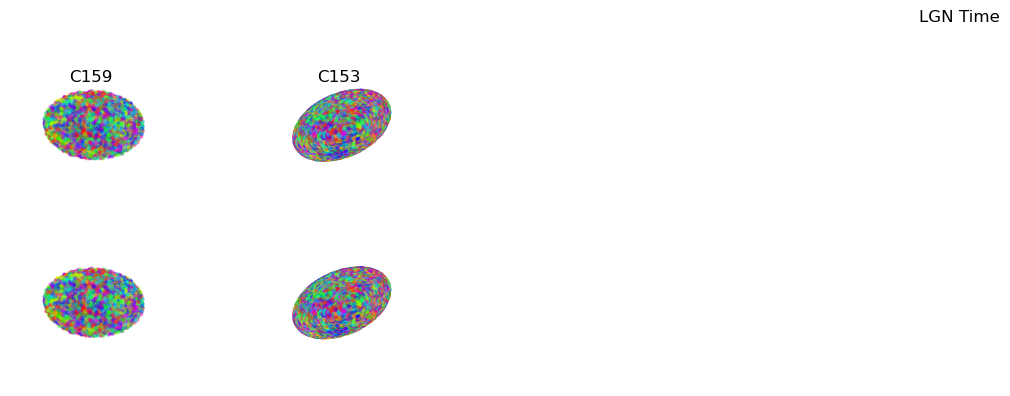

In [89]:
file_path = r'C:\Users\denmanlab\Desktop\Emily_rotation\CEBRA\8d\shuffled\embeddings\LGN_8d_shuffled_color_exchange.pkl'
plot_3d_CEBRA(file_path, ncols=4)

# Workflow

In [73]:
import os
import glob
from pathlib import Path

if __name__ =="__main__":
    # parameters
    embedding_directory = r"C:\Users\denmanlab\Desktop\Emily_rotation\CEBRA\32d\shuffled\embeddings"  # Directory containing embedding pickle files
    file_pattern = "V1_32d_shuffled_drifting_gratings.pkl"  # Pattern to match embedding files
    dims = 3 # dims of embedding
    maxdim = 2 # homology groups
    build_lib = False # stores persistence digrams in lib to save

    #KNN matrix
    n_neighbors = 300 
    matrix_metric = 'cosine'
    plot_matrix = False
    matrix_plot_title = " "

    #Ripser
    plot_dgms = False # to plot persistence diagram
    
    # Output directories
    output_dir = r"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_shuffled\32d"
    os.makedirs(output_dir, exist_ok=True)
    
    # Find all embedding files
    embedding_files = glob.glob(os.path.join(embedding_directory, file_pattern))
    
    if not embedding_files:
        print(f"No files found matching pattern: {file_pattern}")
    else:
        for file in embedding_files:
            print(f"{os.path.basename(file)}")
        
        for file_idx, embedding_path in enumerate(embedding_files):
            filename = os.path.basename(embedding_path)
            file_stem = Path(filename).stem  # Remove .pkl extension
            
            print(f"\nProcessing file {file_idx + 1}/{len(embedding_files)}: {filename}")
            
            try:
                # Load the embedding data
                session = pd.read_pickle(embedding_path)
                
                # Extract session names
                session_names = list(session.keys())
                print(f"  Found {len(session_names)} sessions: {session_names}")
                
                # Process each session
                for session_name in session_names:
                    print(f"    Processing session: {session_name}")
                    
                    # Extract embedding
                    embedding = session[session_name]['embedding']

                    # Downsample embedding
                    ds_embedding = fps_downsample_embedding(embedding, n_target=10000)
                    
                    # Create KNN sparse matrix
                    sparse_matrix = knn_sparse_dist(ds_embedding, n_neighbors, matrix_metric, 
                                                  plot_matrix, matrix_plot_title)
                    
                    # Compute persistence diagrams
                    dgms = tda_ripser(sparse_matrix, session_name, maxdim, dims, plot_dgms, build_lib)
                    
                    # Create output filenames based on input file
                    output_base = f"{file_stem}_{session_name}"
                    pkl_output_path = os.path.join(output_dir, f"{output_base}_dgms.pkl")
                    
                    # Save persistence diagrams as pickle
                    with open(pkl_output_path, 'wb') as f:
                        pkl.dump(dgms, f)
                    print(f"Saved persistence diagrams: {pkl_output_path}")
                    
                   
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
                continue
        
        print(f"Results saved in directory: {output_dir}")
        
        # List saved files
        saved_files = glob.glob(os.path.join(output_dir, "*"))
        if saved_files:
            print(f"\nSaved files ({len(saved_files)}):")
            for file in sorted(saved_files):
                print(f"  - {os.path.basename(file)}")


V1_32d_shuffled_drifting_gratings.pkl

Processing file 1/1: V1_32d_shuffled_drifting_gratings.pkl
  Found 2 sessions: ['C159', 'C160']
    Processing session: C159
Saved persistence diagrams: C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_shuffled\32d\V1_32d_shuffled_drifting_gratings_C159_dgms.pkl
    Processing session: C160
Saved persistence diagrams: C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_shuffled\32d\V1_32d_shuffled_drifting_gratings_C160_dgms.pkl
Results saved in directory: C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_shuffled\32d

Saved files (15):
  - LGN_32d_shuffled_chromatic_gratings_C159_dgms.pkl
  - LGN_32d_shuffled_colored_exchange_C153_dgms.pkl
  - LGN_32d_shuffled_colored_exchange_C159_dgms.pkl
  - LGN_32d_shuffled_drifting_gratings_C159_dgms.pkl
  - LGN_32d_shuffled_luminance_flash_C159_dgms.pkl
  - LGN_32d_shuffled_luminance_flash_C160_dgms.pkl
  - V1_32d_shuffled_chromatic_gratings_C161_dgms.pkl
  - V1_32d_shuffled_color_exchange_C15

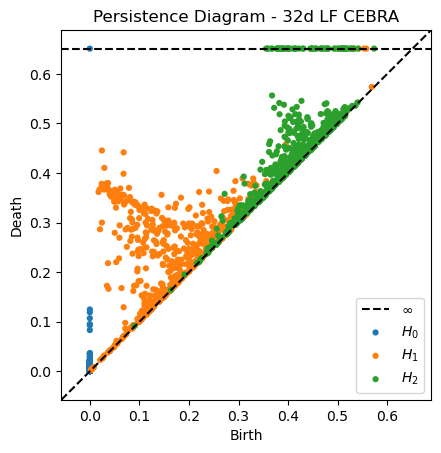

In [85]:
# plot persistence diagram

with open(r"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_shuffled\LGN_32d_shuffled_luminance_flash_C160_dgms.pkl", 'rb') as f:
    dgms = pkl.load(f)

from persim import plot_diagrams
plot_diagrams(dgms, title="Persistence Diagram - 32d LF CEBRA", show=True)